# LSTM PREDICCIÓN DE CONSUMOS

## Import de las librerías necesarias

In [81]:
import itertools
import pickle

import keras
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd
import seaborn as sns
import sweetviz as sv
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.utils import np_utils
from sklearn import metrics  # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split  # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler  # for normalization

## Análisis Exploratorio de Datos

In [82]:
#Lectura del archivo
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'Fecha' : ['Date', 'Time']},
                 infer_datetime_format=True, 
                 low_memory=False,
                 na_values=['nan','?'],
                 index_col='Fecha')

In [83]:
#Tratamiento de NaN
df = df.interpolate()
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [84]:
#Eliminar voltaje y energia reativa
df = df.drop(['Voltage','Global_reactive_power'], axis=1)

In [85]:
#Cambio de unidades a KWh
df['Sub_metering_1'] = df['Sub_metering_1']/1000
df['Sub_metering_2'] = df['Sub_metering_2']/1000
df['Sub_metering_3'] = df['Sub_metering_3']/1000

#Cambio de potencia a energia (kWh)
df['Energia activa global'] = df['Global_active_power']/60
#df['Energia reactiva global'] = df['Global_reactive_power']/60

#Medidor 4
df['Sub_metering_4'] = df['Energia activa global']-(df['Sub_metering_1']+df['Sub_metering_2']+df['Sub_metering_3'])

#Creacion del nuevo dataframe
df_mean = df[['Global_intensity']].copy()
df_sum = df.drop(['Global_intensity', 'Global_active_power'], axis=1)

In [86]:
#Resampling del nuevo dataframe
df_mean = df_mean.resample('h').mean()
df_sum = df_sum.resample('h').sum()

df1 = df_mean.merge(df_sum, left_index=True, right_index=True)


#Mover energia activa a la ultima posicion
brb = df1.pop('Energia activa global') # remove column b and store it in brb
df1.insert(0, 'Energia activa global', brb) # en primera posicion

<AxesSubplot:title={'center':'Matriz de correlación'}>

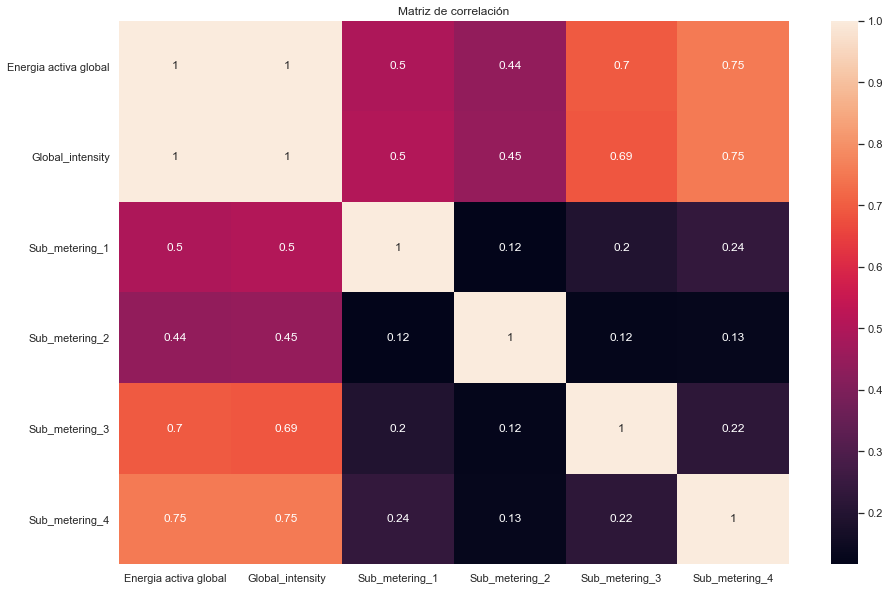

In [87]:
correlation_matrix = df1.corr()

plt.figure(figsize = (15,10))
plt.title('Matriz de correlación')
sns.heatmap(data=correlation_matrix, annot=True)

<AxesSubplot:xlabel='Energia activa global', ylabel='Probability'>

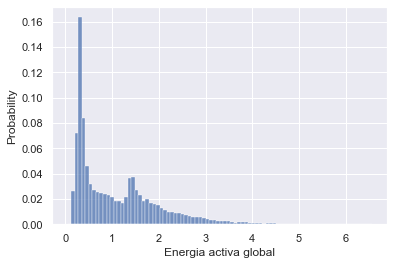

In [88]:
sns.set_theme(style='darkgrid')
sns.histplot(df1['Energia activa global'], stat='probability')

# Construcción del modelo

In [89]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Escalar los datos

In [90]:
n_hours = 24
n_features = df1.shape[1]

values = df1.values
scaler = MinMaxScaler()
scaler = scaler.fit(values)
scaled = scaler.transform(values)

In [91]:
#Save the scaler
pickle.dump(scaler, open('scaler.pkl','wb'))

In [93]:
supervised = series_to_supervised(scaled, n_hours, 1)

In [95]:
#Eliminamos variables que no vayan a predecirse
variables_eliminadas = supervised.columns[-(n_features-1):]
supervised.drop(variables_eliminadas, axis=1, inplace=True)

### Train test split

In [96]:
# Dividir en entrenamiento y test
values = supervised.values

n_train_time = int(supervised.shape[0]*0.75)
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# Dividir en entradas y salidas
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [97]:
# Redimensionar el input a 3d [muestras, secuencias, variables]
X_train = X_train.reshape((X_train.shape[0], n_hours, n_features))
X_test = X_test.reshape((X_test.shape[0], n_hours, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25923, 24, 6) (25923,) (8642, 24, 6) (8642,)


### Definir el modelo

In [98]:
early_stopping = EarlyStopping(
    min_delta=0.0005, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [99]:
#Preparar la red LSTM
units = 100
#n_outputs = y_train.shape[1]

model = Sequential()
model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

### Adaptar el modelo a los datos

Epoch 1/50
406/406 [==============================] - 20s 40ms/step - loss: 0.0139 - val_loss: 0.0081
Epoch 2/50
406/406 [==============================] - 15s 38ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 3/50
406/406 [==============================] - 16s 38ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 4/50
406/406 [==============================] - 16s 40ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 5/50
406/406 [==============================] - 15s 38ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 6/50
406/406 [==============================] - 15s 37ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 7/50
406/406 [==============================] - 16s 40ms/step - loss: 0.0080 - val_loss: 0.0064
Epoch 8/50
406/406 [==============================] - 16s 39ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 9/50
406/406 [==============================] - 15s 38ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 10/50
406/406 [==============================] - 16s 40ms/step - loss: 0.007

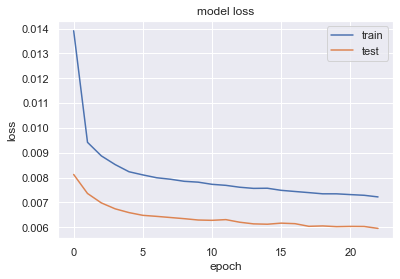

In [100]:
#Elegir hiperparametros
batch_size = 64
epochs = 50

# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False, callbacks=[early_stopping])

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Resultados

In [101]:
# Hacer una predicción
yhat = model.predict(X_test)
X_test2 = X_test.reshape((X_test.shape[0], n_hours*n_features))
# Invertir el escalado de la predicción
inv_yhat = np.concatenate((yhat, X_test2[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invertir el escalado del real
test_y = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((test_y, X_test2[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calcular RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.513


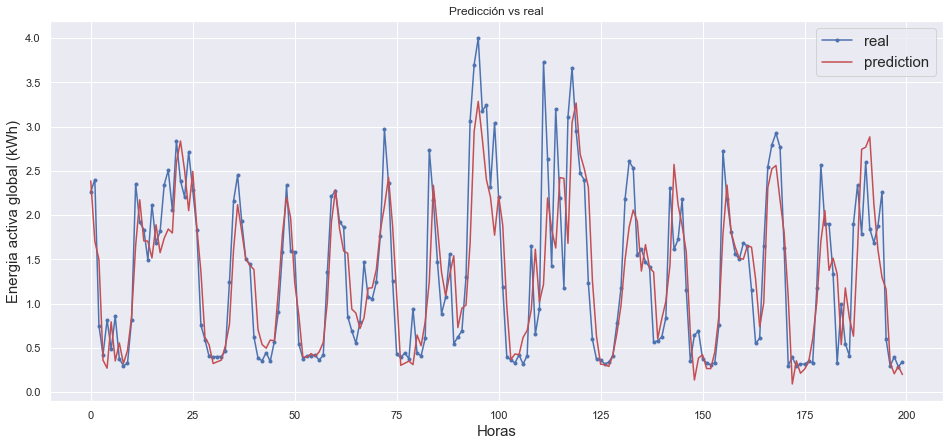

In [102]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

hours = 200

plt.figure(figsize = (16,7))
plt.title('Predicción vs real')

aa=[x for x in range(hours)]
plt.plot(aa, inv_y[:hours], marker='.', label="real")
plt.plot(aa, inv_yhat[:hours], 'r', label="prediction")
plt.ylabel('Energia activa global (kWh)', size=15)
plt.xlabel('Horas', size=15)
plt.legend(fontsize=15)
plt.show()

## Funciones añadidas

In [103]:
# Guardar el Modelo
#model.save('consumos_model.h5')

In [78]:
# Recrea exactamente el mismo modelo solo desde el archivo
model = keras.models.load_model('consumos_model.h5')

## Iterar para encontrar los mejores hiperparámetros

In [81]:
#Hiperparametros

n_units = [50,100,150,250]
n_capas = [1,2]
n_batch_size = [32, 64]
epochs = 50
i=0
best = 10000
errores = []
parametros = []

for capas in n_capas:
    
    for batch_size in n_batch_size:
        
        for units in n_units:
            
            # Dividir en entrenamiento y test
            values = supervised.values

            n_train_time = int(supervised.shape[0]*0.75)
            train = values[:n_train_time, :]
            test = values[n_train_time:, :]

            # Dividir en entradas y salidas
            X_train, y_train = train[:, :-1], train[:, -1]
            X_test, y_test = test[:, :-1], test[:, -1]
            
            # Redimensionar el input a 3d [muestras, secuencias, variables]
            X_train = X_train.reshape((X_train.shape[0], n_hours, n_features))
            X_test = X_test.reshape((X_test.shape[0], n_hours, n_features))
            
            #Configurar modelo
            if(capas==1):
                model = Sequential()
                model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
                model.add(Dropout(0.2))
                model.add(Dense(1))
                model.compile(loss='mse', optimizer='adam')
            if(capas==2):
                model = Sequential()
                model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
                model.add(Dropout(0.2))
                model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
                model.add(Dropout(0.2))
                model.add(Dense(1))
                model.compile(loss='mse', optimizer='adam')


            # fit network
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False, callbacks=[early_stopping])

            # Hacer una predicción
            yhat = model.predict(X_test)
            X_test2 = X_test.reshape((X_test.shape[0], n_hours*n_features))
            # Invertir el escalado de la predicción
            inv_yhat = np.concatenate((yhat, X_test2[:, -(n_features-1):]), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,0]
            # Invertir el escalado del real
            test_y = y_test.reshape((len(y_test), 1))
            inv_y = np.concatenate((test_y, X_test2[:, -(n_features-1):]), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,0]
            # calcular RMSE
            rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
            print('--------')
            print('Iteración número ', i)
            print('Parametros:')
            print('Capas =', capas)
            print('Units =', units)
            print('Batch Size =', batch_size)
            print('Test RMSE: %.3f' % rmse)
            print('--------')
            print()
            current_parametros = {
                'iteracion': i,
                'units': units,
                'batch_size': batch_size,
                'capas': capas,
                'error': rmse
            }
            parametros.append(current_parametros)
            print('--------')
            errores.append(rmse)
            if(rmse < best):
                best_model = model
                best = rmse
                best_parametros = current_parametros
            i+=1

results=pd.DataFrame(parametros)
results.to_excel('errores.xlsx')
results.loc[results['error'].idxmin()]
# Guardar el Modelo
best_model.save('best_model.h5')

Epoch 1/50
810/810 [==============================] - 16s 18ms/step - loss: 0.0129 - val_loss: 0.0077
Epoch 2/50
810/810 [==============================] - 15s 18ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 3/50
810/810 [==============================] - 14s 18ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 4/50
810/810 [==============================] - 15s 18ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 5/50
810/810 [==============================] - 15s 18ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 6/50
810/810 [==============================] - 15s 18ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 7/50
810/810 [==============================] - 15s 18ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 8/50
810/810 [==============================] - 15s 18ms/step - loss: 0.0077 - val_loss: 0.0063
Epoch 9/50
810/810 [==============================] - 15s 18ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 10/50
810/810 [==============================] - 15s 18ms/step - loss: 0.007

iteracion       9.000000
units         100.000000
batch_size     32.000000
capas           2.000000
error           0.507428
Name: 9, dtype: float64